<a href="https://colab.research.google.com/github/raspiduino/ftc-tfod/blob/main/efficientdet_lite_vi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom training cho FTC TFOD sử dụng model EfficientDet-Lite
## Tại sao lại custom training bằng Google Colab notebook mà không dùng FTC-ML tool?
FTC-ML là tool chính thức của FTC được thiết kế để train custom model cho TFOD (TensorFlow Object Detection) API trong FTC SDK. Tuy nhiên, FTC-ML còn tồn tại một số hạn chế nhất định (quan điểm cá nhân):
- Thời gian training bị giới hạn ở **tối đa 600 phút** cho tổng tất cả các lần training của một team. Nếu train hết khoảng thời gian này, team sẽ **không có cách nào để lấy thêm thời gian train** (FTC-ML **không** cho phép mua thêm thời gian)
- Các team không thể upload ảnh lên FTC-ML mà buộc phải quay video và tải video lên
- Việc tải video lên FTC-ML **chỉ được thực hiện bằng tài khoản mentor**, tài khoản youth chỉ có thể label frame và train. Điều này sẽ sinh ra một số bất tiện, khi không phải lúc nào mentor cũng có thể upload video lên để cho youth train model.
- FTC-ML không cho phép tùy chỉnh các thông số trong quá trình train ([nguồn FTC-ML docs](https://ftc-docs.firstinspires.org/en/latest/ftc_ml/faq/faq.html#i-read-somewhere-about-a-parameter-i-can-tweak))
- FTC-ML có một số giới hạn về dataset ([nguồn FTC-ML docs](https://ftc-docs.firstinspires.org/en/latest/ftc_ml/faq/faq.html#what-are-the-limitations-imposed-within-the-ftc-ml-tool-per-team))
- Việc lấy dataset đã được label từ nhiều nguồn để phục vụ việc train model là khá khó khăn, vì FTC-ML chỉ hỗ trợ upload video và label object trực tiếp trên trang của FTC-ML.

Do vậy, notebook này được ra đời, với mục đích mang tới sự thuận tiện cho việc training model TFOD của các team FTC. Hiện tại, notebook được sử dụng để train model `EfficientDet-Lite[0-4]`. Trong tương lai, các model khác có thể được thêm vào nhằm mang tới sự đa dạng lựa chọn cho các team.

Notebook này được tạo ra bởi team FTC của GreenAms Robotics Team. Trong quá trình xây dựng không thể tránh khỏi những thiếu sót, rất mong các team có ý kiến đóng góp xây dựng để notebook ngày càng hoàn thiện hơn. Xin cảm ơn!

## Sơ lược về quá trình từ chụp ảnh, tạo dataset đến training, thu được model
Để có được một model TFOD phục vụ nhận diện vật thể (object recognition) cho cuộc thi FTC thì cần trải qua một quá trình gồm nhiều bước, tuy nhiên có thể tóm gọn đơn giản các bước được sử dụng trong notebook này như sau:
- Bước 1: Thu thập dữ liệu (ảnh, video, ...)
- Bước 2: Dán nhãn (label) dữ liệu (annotate các object trong ảnh)
- Bước 3: Pre-process dữ liệu (chỉnh cỡ tất cả ảnh về 1 size,...)
- Bước 4: Export dataset ra và tải về notebook
- Bước 5: Setup môi trường training
- Bước 6: Train
- Bước 7: Lấy file `.tflite` thu được và mang lên robot để chạy

Lưu ý: trong quá trình chạy, các team vẫn có thể chụp thêm ảnh (đặc biệt là ảnh bị nhận diện sai/lỗi) để cho vào train lại và cải thiện model.

Sau đây là chi tiết các bước:

### Bước 1: Thu thập dữ liệu (ảnh, video, ...)
- Các team cần chụp ảnh (hoặc kể cả quay video nếu muốn) về vật thể mà mình muốn nhận diện. Việc chụp ảnh cần được **thực hiện nhiều lần**, **ở các góc độ khác nhau của vật thể** (chú ý các **góc độ mà camera trên con bot hay nhìn được**), ở các **điều kiện ánh sáng khác nhau** (tốt nhất là độ sáng vừa phải hoặc như trên sân đấu, **không nên quá sáng hoặc quá tối**).
- Việc chụp ảnh không nên chỉ dừng lại ở chụp mỗi vật thể mà mình muốn nhận diện, mà các team nên cho cả những vật thể không liên quan nhưng có thể tồn tại trên sân đấu vào trong một số ảnh, xen lẫn hoặc cùng với vật thể mình muốn nhận diện, để model có thể phân biệt và loại đi các vật thể nhiễu tốt hơn.
- Các team thi thoảng cũng nên chụp một số ảnh không có vật thể nào, để model giảm bớt khả năng nhận nhầm vật khi không có vật

Sau khi chụp ảnh, các bạn cần một nơi để lưu và xử lý ảnh. Ở đây, chúng mình thường sử dụng trang web https://roboflow.com, nơi các bạn có thể tải ảnh, label ảnh, convert dataset trực tuyến, cho phép nhiều người tham gia và vô cùng thuận tiện. Notebook này sẽ hướng dẫn các bạn sử dụng trang web đó cho mục đích tạo dataset cho training.

### Phụ lục: Sử dụng Roboflow
- Bước 1: Các bạn vào https://app.roboflow.com/login để đăng nhập / tạo tài khoản
- Bước 2: Sau khi tạo tài khoản thành công, các bạn tiến hành tạo workspace

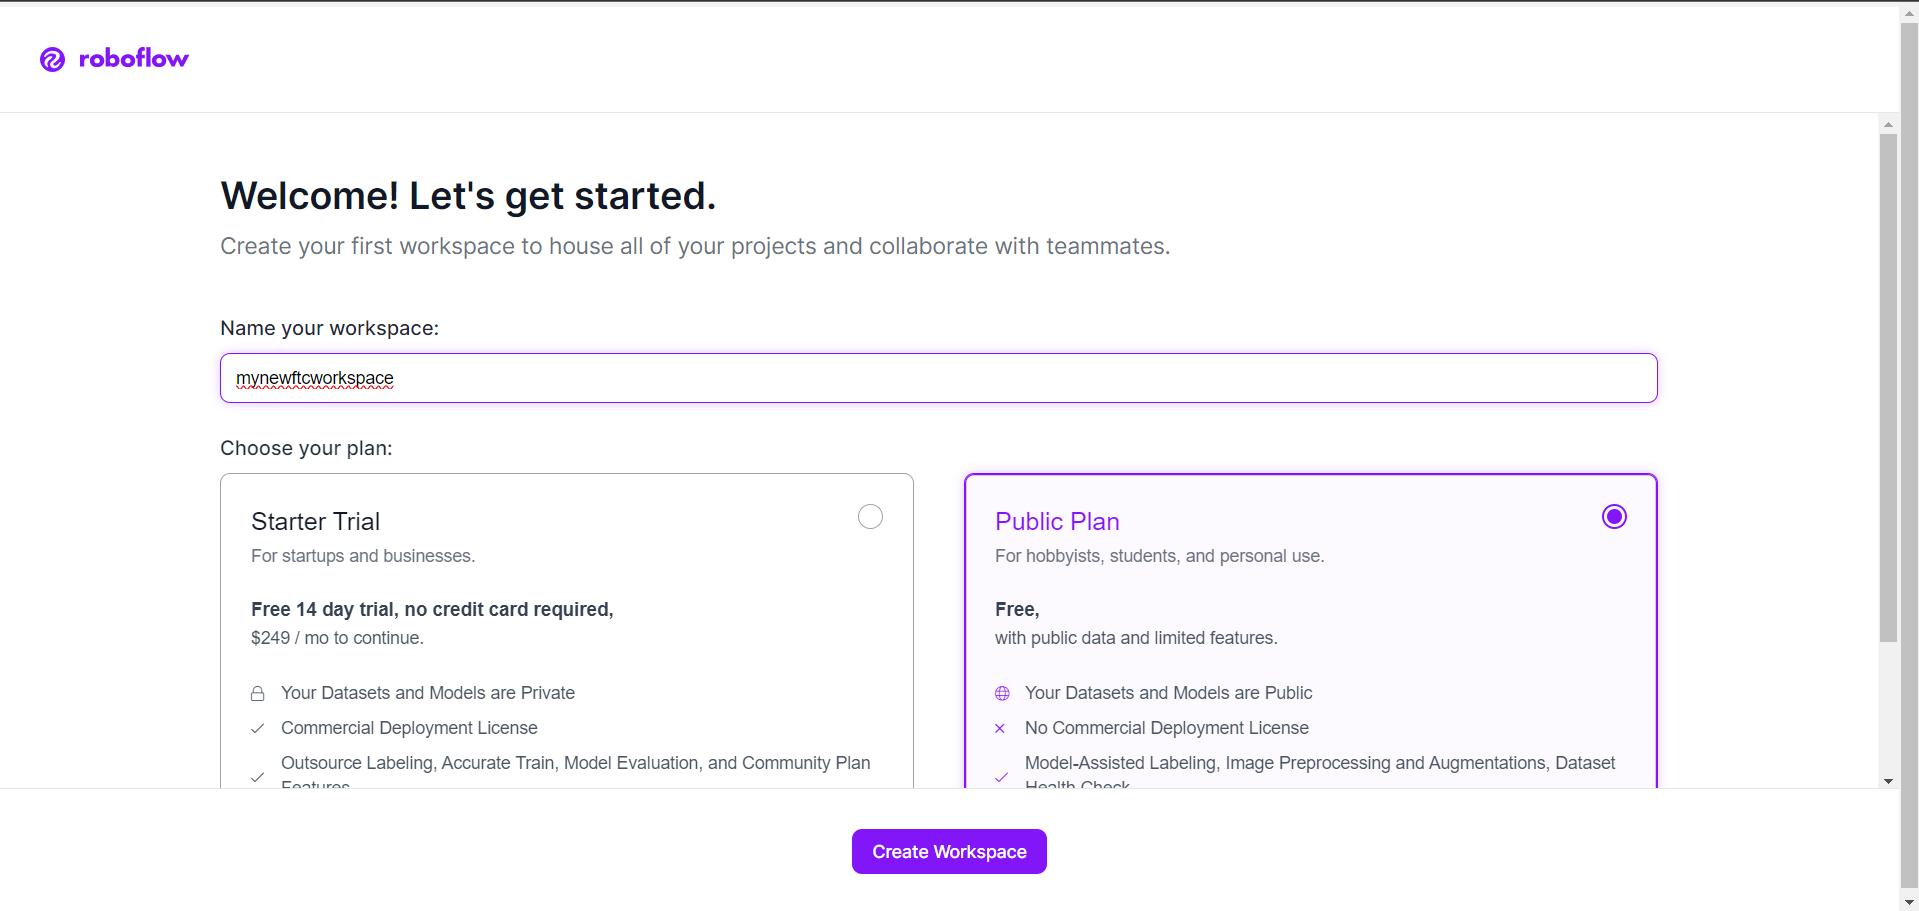
- Bước 3: Đặt tên và tạo project của mình

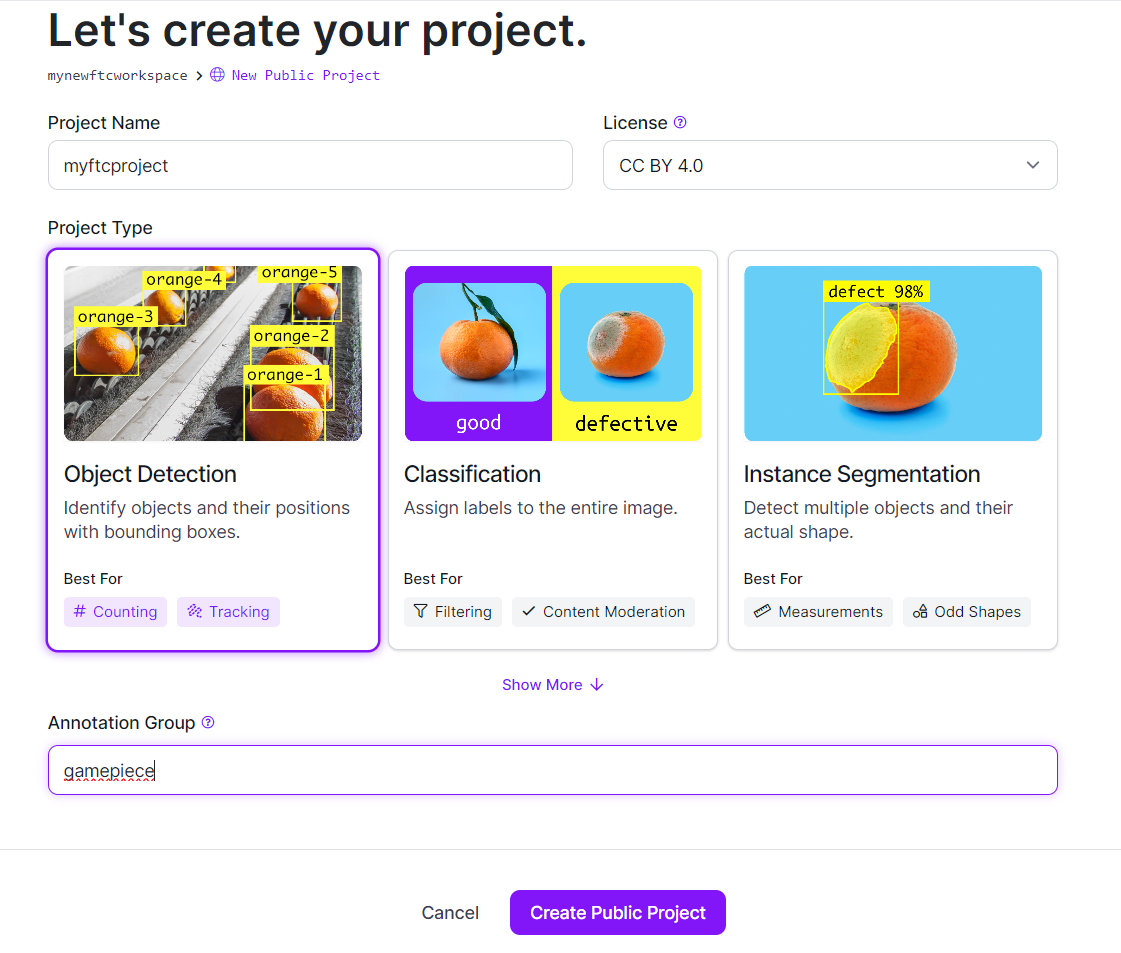
- Bước 4: Giờ các bạn có thể tự do tải ảnh lên project của mình

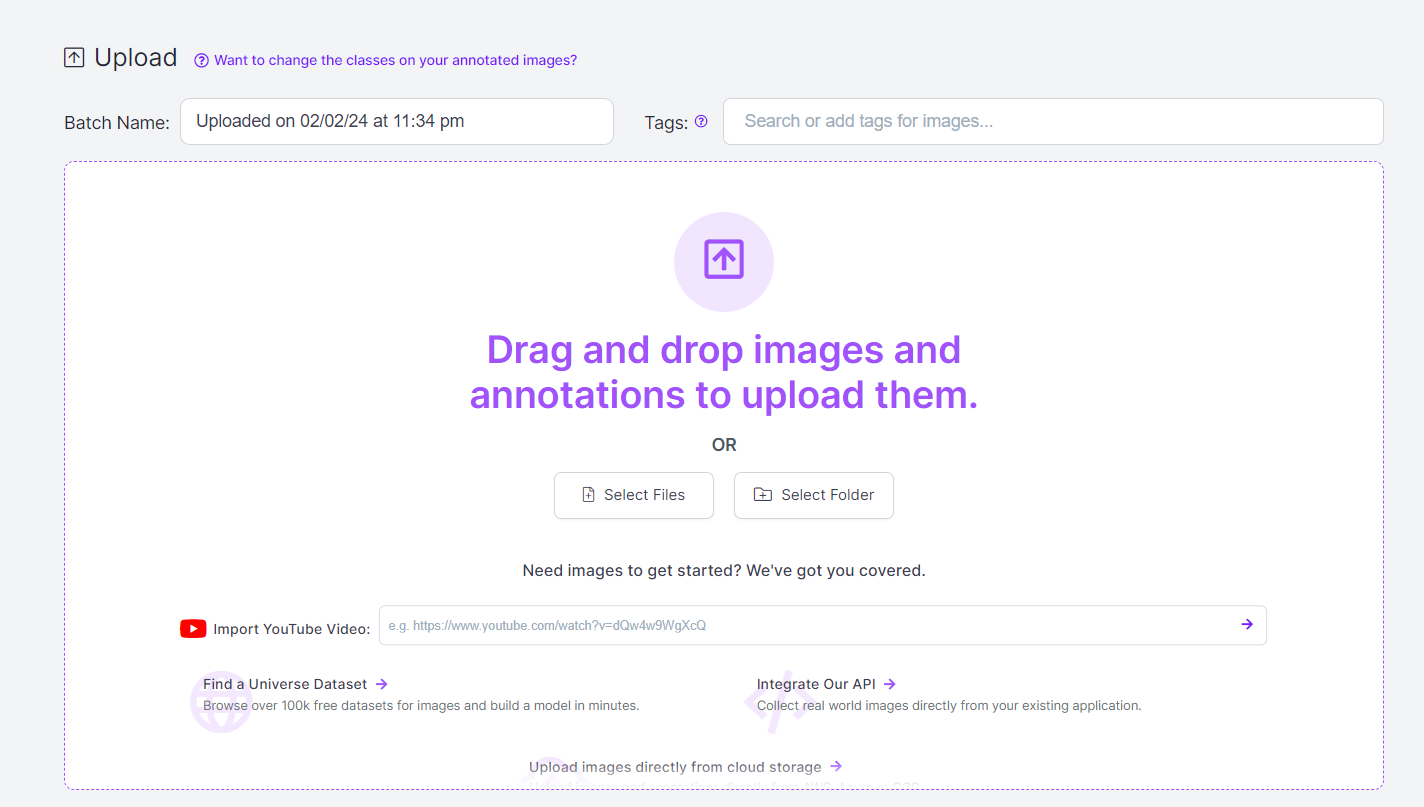

### Bước 2: Label (dán nhãn) dữ liệu
- Bước 2.1: Sau khi tải ảnh lên, các bạn vào mục Annotate để tiến hành dán nhãn cho ảnh

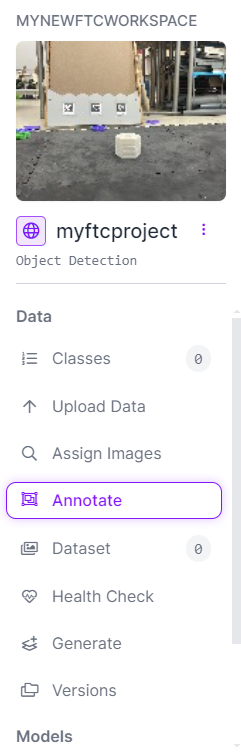

- Bước 2.2: Bấm `Start annotating` để bắt đầu

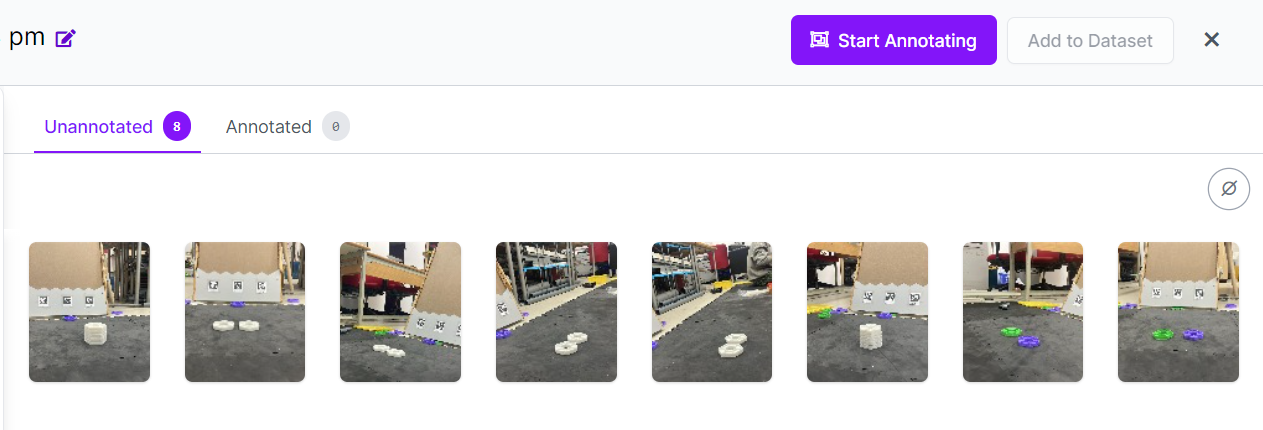

- Bước 2.3: Vẽ hình chữ nhật **vừa đủ bao toàn bộ vật thể** của bạn trên ảnh. Hình chữ nhật này gọi là *bounding box*.
- Bước 2.4: Một ô nhập label (nhãn) sẽ hiện lên, các bạn điền tên vật thể vào. **Lưu ý:** các vật thể bạn muốn xác định là cùng loại thì cần để cùng một tên.

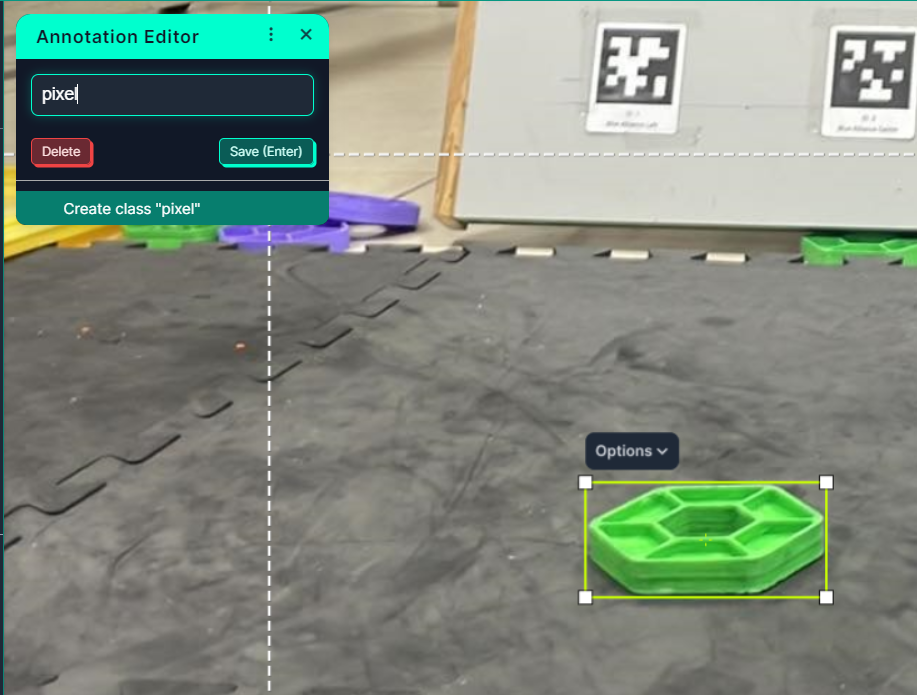
Bấm `Enter` để lưu. Lặp lại cho đến khi hết vật thể bạn muốn nhận diện trong ảnh. **Lưu ý**: nếu có nhiều loại vật thể trong ảnh, các bạn tô từng vật thể rồi để tên ứng với từng loại là được. Sau khi xong với một ảnh thì các bạn bấm mũi tên để chuyển sang ảnh khác. Lặp lại đến khi hết ảnh.
- Bước 2.5: Add ảnh đã annonate vào dataset

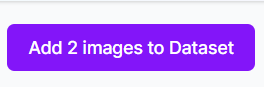

### Bước 3: Preprocess dữ liệu
- Bước 3.1: Vào mục `Generate`:

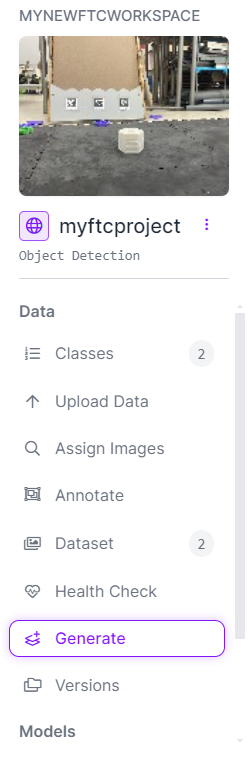

- Bước 3.2: Chỉnh cỡ trong phần resize về khoảng 320x320 trở xuống, loại resize là `Stretch to`:

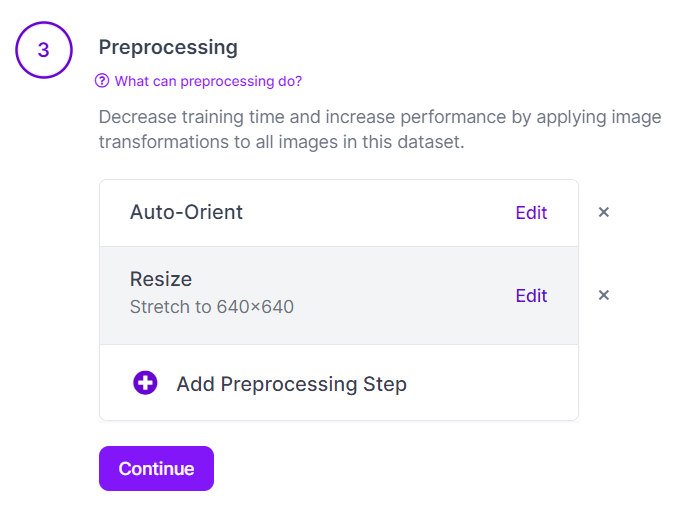

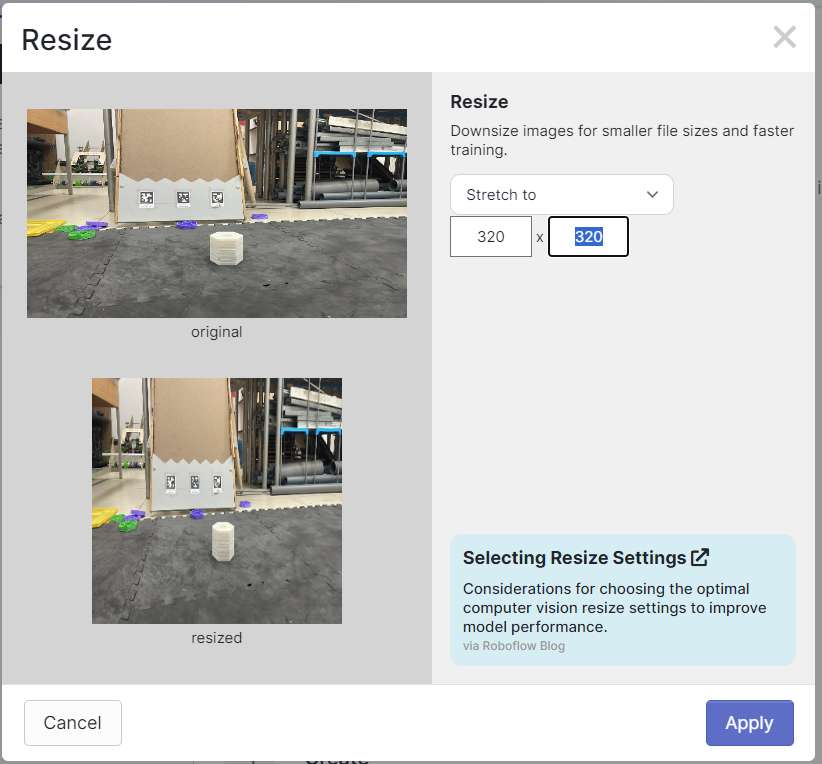

- Bước 3.3 (tùy chọn): Nếu dataset của bạn có quá ít ảnh, bạn có thể dùng `Augmentation` để tăng số lượng ảnh, tuy nhiên chỉ nên chọn một số hiệu ứng như crop, rotation, brightness,...

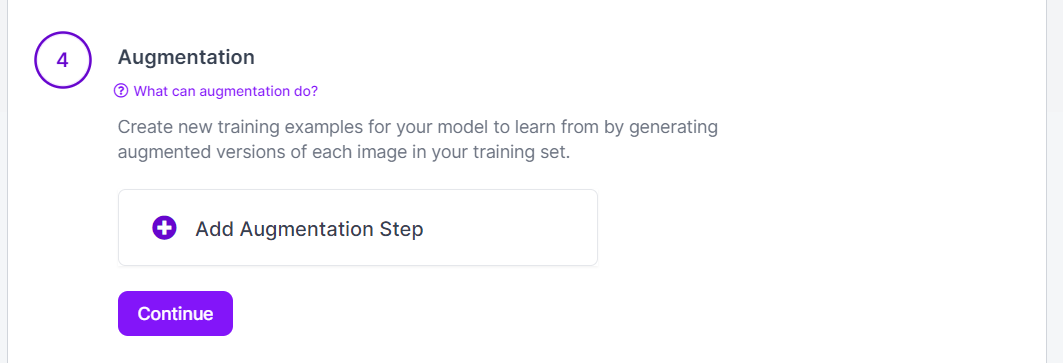

- Bước 3.4: Cuối cùng, bấm create để generate

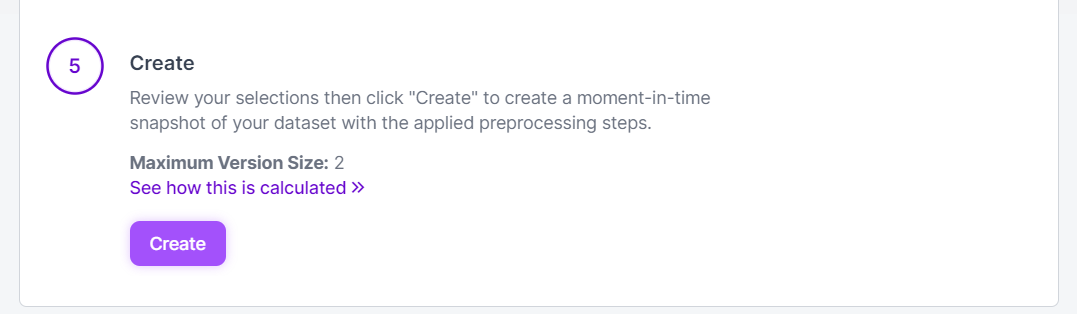

### Bước 4: Export dataset ra và tải về notebook

- Bước 4.1: Chọn `Export dataset` rồi chọn `Pascal VOC`, bấm `show download code` rồi `Continue`

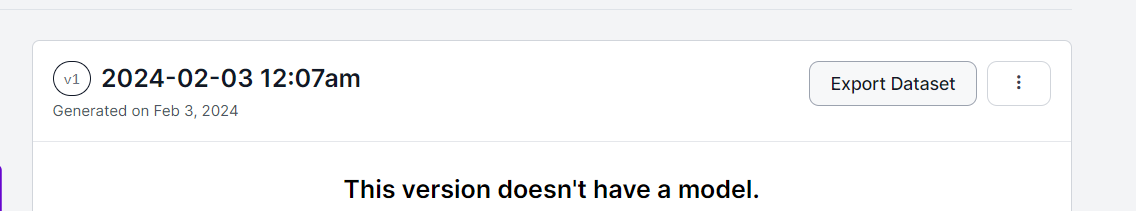

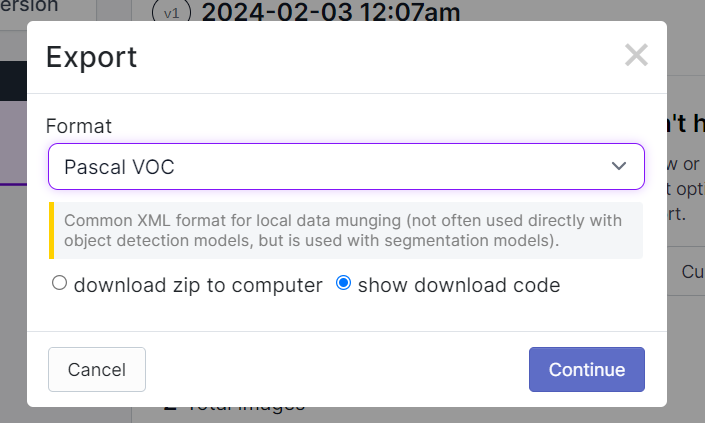

- Bước 4.2: Copy download code của bạn để dùng trong bước tiếp theo

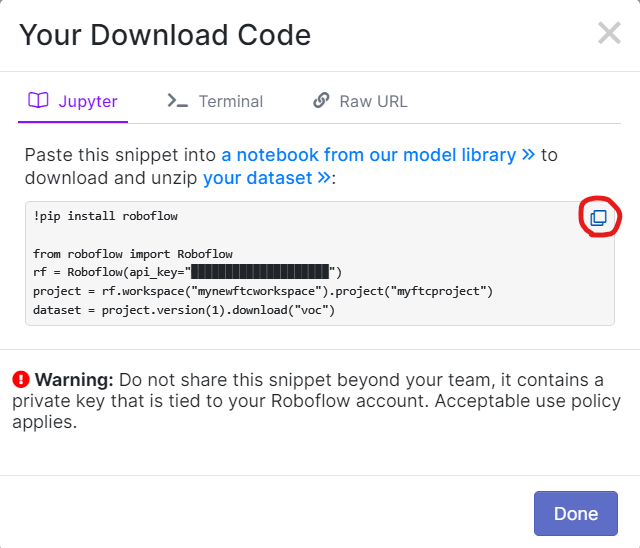

- Bước 4.3: Paste code bạn copy được ở Roboflow vào cell dưới đây và chạy:

In [ ]:
# Paste code bạn vừa copy vào đây và chạy

Xin chúc mừng, bạn vừa download thành công dataset về notebook
### Bước 5: Setup môi trường training
Việc của bạn trong bước này rất đơn giản: chạy từng cell tính từ cell dưới đến khi hết bước 5, sang bước 6

In [ ]:
# Tải script setup miniconda3
%env PYTHONPATH = # /env/python

!wget https://repo.anaconda.com/miniconda/Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
!chmod +x Miniconda3-py39_23.3.1-0-Linux-x86_64.sh

env: PYTHONPATH=# /env/python
--2024-02-02 14:42:37--  https://repo.anaconda.com/miniconda/Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70605094 (67M) [application/x-sh]
Saving to: ‘Miniconda3-py39_23.3.1-0-Linux-x86_64.sh’

Miniconda3-py39_23. 100%[===================>]  67.33M   138MB/s    in 0.5s    

2024-02-02 14:42:38 (138 MB/s) - ‘Miniconda3-py39_23.3.1-0-Linux-x86_64.sh’ saved [70605094/70605094]



In [ ]:
# Cài đặt miniconda
!./Miniconda3-py39_23.3.1-0-Linux-x86_64.sh -b -f -p /usr/local
!conda update conda -y

PREFIX=/usr/local
Unpacking payload ...
                                                                                      
Installing base environment...





Preparing transaction: - \ | / done
Executing transaction: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /usr/local
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |          

In [ ]:
# Thêm đường dẫn site-package của python3.9 vào path
import sys
sys.path.append('/usr/local/lib/python3.9/site-packages')

In [ ]:
# Tạo môi trường ảo bằng conda
!conda create -n myenv python=3.9 -y

Channels:
 - defaults
Platform: linux-64
Solving environment: / done

## Package Plan ##

  environment location: /usr/local/envs/myenv

  added / updated specs:
    - python=3.9


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pip-23.3.1                 |   py39h06a4308_0         2.6 MB
    setuptools-68.2.2          |   py39h06a4308_0         948 KB
    wheel-0.41.2               |   py39h06a4308_0         108 KB
    ------------------------------------------------------------
                                           Total:         3.6 MB

The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main 
  _openmp_mutex      pkgs/main/linux-64::_openmp_mutex-5.1-1_gnu 
  ca-certificates    pkgs/main/linux-64::ca-certificates-2023.12.12-h06a4308_0 
  ld_impl_linux-64   pkgs/main/linux-64::ld_impl_linux-64-2.38-h1181459_1 
  libffi      

In [ ]:
# Cài đặt cudnn
!conda uninstall cudatoolkit -y
!conda install cudnn -y


PackagesNotFoundError: The following packages are missing from the target environment:
  - cudatoolkit


Channels:
 - defaults
Platform: linux-64
Solving environment: | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudnn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cudatoolkit-11.8.0         |       h6a678d5_0       630.7 MB
    cudnn-8.9.2.26             |         cuda11_0       469.4 MB
    ------------------------------------------------------------
                                           Total:        1.07 GB

The following NEW packages will be INSTALLED:

  cudatoolkit        pkgs/main/linux-64::cudatoolkit-11.8.0-h6a678d5_0 
  cudnn              pkgs/main/linux-64::cudnn-8.9.2.26-cuda11_0 


Proceed ([y]/n)? y


cudatoolkit-11.8.0   | 630.7 MB  | :   0% 0/1 [00:00<?, ?it/s]
cudatoolkit-11.8.0   | 630.7 MB  | :   0% 2.477

In [ ]:
# Cài đặt các package cần sử dụng
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv
pip install tflite-model-maker pycocotools tflite-support ipykernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.8/203.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.1

### Bước 6: Train
Trước khi chạy cell dưới, các bạn cần phải thay đổi một số thứ:

Thay đổi cần thiết:

- Đoạn này cần đổi đường dẫn về đúng đường dẫn của bạn: thay thế `/content/CenterStageFTC-4` bằng `/content/[Tên project của bạn]-[mã version bạn tải]`. Ví dụ, tên project của bạn là `myftcproject` và mã version của bạn là v1 thì bạn thay bằng `/content/myftcproject-1`
```
# Load dataset
train_data = object_detector.DataLoader.from_pascal_voc("/content/CenterStageFTC-4/train", "/content/CenterStageFTC-4/train", label_map=label_map)
validation_data = object_detector.DataLoader.from_pascal_voc("/content/CenterStageFTC-4/valid", "/content/CenterStageFTC-4/valid", label_map=label_map)
test_data = object_detector.DataLoader.from_pascal_voc("/content/CenterStageFTC-4/test", "/content/CenterStageFTC-4/test", label_map=label_map)
```

Thay đổi tùy chọn (nếu các bạn không cần thay đổi thì cũng không nên đổi):

- Các bạn có thể đổi model sử dụng ở dòng `spec = model_spec.get('efficientdet_lite2')`. Tên các model và thông số được cho ở bảng sau:

|       Tên model      | Kích thước file `.tflite`(MB) |  Độ trễ (tỉ lệ)* | Độ chính xác (tỉ lệ)** |
|----------------------|-------------------------------|------------------|----------------------|
| `efficientdet_lite0` | 4.4       | 37            | 25.69%               |
| `efficientdet_lite1` | 5.8       | 49            | 30.55%               |
| `efficientdet_lite2` | 7.2       | 69            | 33.97%               |
| `efficientdet_lite3` | 11.4      | 116           | 37.70%               |
| `efficientdet_lite4` | 19.9      | 260           | 41.96%               |

Lưu ý:

\*: độ trễ đo bằng ms trên thiết bị Pixel 4, **KHÔNG** phải trên Control Hub. Ở đây các bạn có thể dùng để so sánh tỉ lệ tốc độ của các model.

\*\*: Độ chính xác khi khảo sát với dataset COCO (gồm hơn 70 classes) và **KHÔNG** phải độ chính xác khi nhận diện vật thể trong FTC. Ở đây các bạn có thể dùng để tham khảo so sánh về tỉ lệ giữa các model.

- Trong dòng `model = object_detector.create(train_data, model_spec=spec, batch_size=16, epochs=40, train_whole_model=True, validation_data=validation_data)`, các bạn có thể thay đổi các tham số như `batch_size` và `epochs` giống như trong mô tả của docs FTC-ML.

Sau khi hoàn tất các chỉnh sửa (nếu có), hãy chạy cell bên dưới

In [ ]:
%%writefile train.py
# Import libraries
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

# Get model
spec = model_spec.get('efficientdet_lite2')

# Label map
label_map = {1: 'pixel'}

# Load dataset
train_data = object_detector.DataLoader.from_pascal_voc("/content/CenterStageFTC-4/train", "/content/CenterStageFTC-4/train", label_map=label_map)
validation_data = object_detector.DataLoader.from_pascal_voc("/content/CenterStageFTC-4/valid", "/content/CenterStageFTC-4/valid", label_map=label_map)
test_data = object_detector.DataLoader.from_pascal_voc("/content/CenterStageFTC-4/test", "/content/CenterStageFTC-4/test", label_map=label_map)

# Train model
model = object_detector.create(train_data, model_spec=spec, batch_size=16, epochs=40, train_whole_model=True, validation_data=validation_data)

# Evaluate TF model
print(model.evaluate(test_data))

# Export to TFLite format
model.export(export_dir='.')

# Evaluate TFLite model
print(model.evaluate_tflite('model.tflite', test_data))


Overwriting train.py


Cuối cùng, chạy cell bên dưới để bắt đầu quá trình training. Việc này sẽ diễn ra trong một khoảng thời gian tương đối lâu. Ví dụ: chúng mình training gần 1000 ảnh mất khoảng gần 50 phút. Hãy kiên nhẫn.

In [ ]:
# Bắt đầu training
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv
LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/pkgs/cudatoolkit-11.8.0-h6a678d5_0/lib/ python train.py

/usr/local/envs/myenv/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/envs/myenv/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to

Sau khi training kết thúc, các bạn hãy chạy cell dưới để tải về model tflite của mình nhé

In [ ]:
from google.colab import files
files.download('model.tflite')

Vậy là các bạn đã train được model TFOD của mình rồi. Xin chúc mừng!

Created by GreenAms Robotics Team (GART)